# Mount and import data from Google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
FOLDER = "/content/drive/My Drive/Colab Notebooks/How to Win a Data Science Competition: Learn from Top Kagglers/data"

In [3]:
!rm -r ./data/
!unzip "$FOLDER/competitive-data-science-predict-future-sales.zip" -d ./data/
!gzip -d ./data/sample_submission.csv.gz
!gzip -d ./data/sales_train.csv.gz
!gzip -d ./data/test.csv.gz
!ls ./data/

rm: cannot remove './data/': No such file or directory
Archive:  /content/drive/My Drive/Colab Notebooks/How to Win a Data Science Competition: Learn from Top Kagglers/data/competitive-data-science-predict-future-sales.zip
  inflating: ./data/test.csv.gz      
  inflating: ./data/sample_submission.csv.gz  
  inflating: ./data/sales_train.csv.gz  
  inflating: ./data/shops.csv        
  inflating: ./data/item_categories.csv  
  inflating: ./data/items.csv        
item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


# Add new libraries

In [4]:
!pip install StringDist pyarrow

    100% |████████████████████████████████| 48.5MB 644kB/s 
  Stored in directory: /root/.cache/pip/wheels/c3/1b/bb/bf0de4d64d8ca38759811fe3353e441f12feb606fb3d1d2e11
Successfully built StringDist


# Load Data into frames

In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import stringdist
from tqdm import tqdm
from shutil import copyfile

In [0]:
FOLDER_PREFIX = "./data"

sales_train = pd.read_csv(f"{FOLDER_PREFIX}/sales_train.csv")
shops = pd.read_csv(f"{FOLDER_PREFIX}/shops.csv")
items = pd.read_csv(f"{FOLDER_PREFIX}/items.csv")
item_categories = pd.read_csv(f"{FOLDER_PREFIX}/item_categories.csv")
sales_test = pd.read_csv(f"{FOLDER_PREFIX}/test.csv")

tmp_frame = pd.merge(sales_train, items, how = "left", on = "item_id")
tmp_frame = pd.merge(tmp_frame, item_categories, how = "left", on = "item_category_id")

## Fix Date into better format

In [0]:
def fix_date_format(input_row):
  split_data = input_row.split(".")
  return f"{split_data[2]}-{split_data[1]}-{split_data[0]}"
   

sales_train["date"] = sales_train["date"].map(lambda input_row: fix_date_format(input_row))
tmp_frame["date"] = tmp_frame["date"].map(lambda input_row: fix_date_format(input_row))

## Show head of tables

In [8]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [9]:
sales_test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [10]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [11]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [12]:
item_categories.head()


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# Visualisation of Features

In [0]:
plt.style.use('ggplot')

In [0]:
def visualize_column_values(input_frame, columns = None, max_bins = 500, log_scale_cols = []):
  if columns == None:
    columns = input_frame.columns
  column_len = len(columns)
  fig, plt_arr = plt.subplots(nrows=column_len, ncols=2, figsize=(20,column_len * 5),
                              gridspec_kw = {'width_ratios':[3, 2]})
  for arr_index in range(column_len):
    if column_len == 1:
      cur_plt = plt_arr
    else:
      cur_plt = plt_arr[arr_index]
    cur_column = columns[arr_index]
    tmp_vals = input_frame[cur_column].values
    dist_vals = np.unique(tmp_vals)
    cur_plt[0].hist(tmp_vals, bins=min(len(dist_vals), max_bins), 
                    log=(cur_column in log_scale_cols))
    cur_plt[0].set_title(cur_column)
  
    
    (min_val, max_val, median_val, mean_val) = get_value_range(input_frame, 
                                                               cur_column)
    (val_05, val_10, val_90, val_95) = get_quantiles(input_frame,
                                                    cur_column)
    cur_plt[1].axis("off")
    cur_plt[1].grid(False)
    table = cur_plt[1].table(cellText=[[min_val],[max_val],
                                       [median_val],[mean_val],
                                       [val_05], [val_10],
                                       [val_90], [val_95]
                                      ],
                  rowLabels=["min", "max", "median", "mean", "Q 5%", "Q 10%", 
                             "Q 90%", "Q 95%"],
                  colWidths = [0.3],
                  loc='center')
    table.set_fontsize(20)
    table.scale(2, 2)
    
  plt.tight_layout()
  plt.show()


def get_value_range(input_frame, column):
  tmp_hist = input_frame.agg({column:["min", "max", "median", "mean"]})[column]
  return (tmp_hist['min'], tmp_hist['max'], tmp_hist['median'], tmp_hist['mean'])
    
  
def get_quantiles(input_frame, input_column):
  tmp_quant = input_frame[input_column].quantile([.05, 0.1, 0.9, .95])
  return (tmp_quant[0.05], tmp_quant[0.1], tmp_quant[0.9], tmp_quant[0.95])

# sales_train

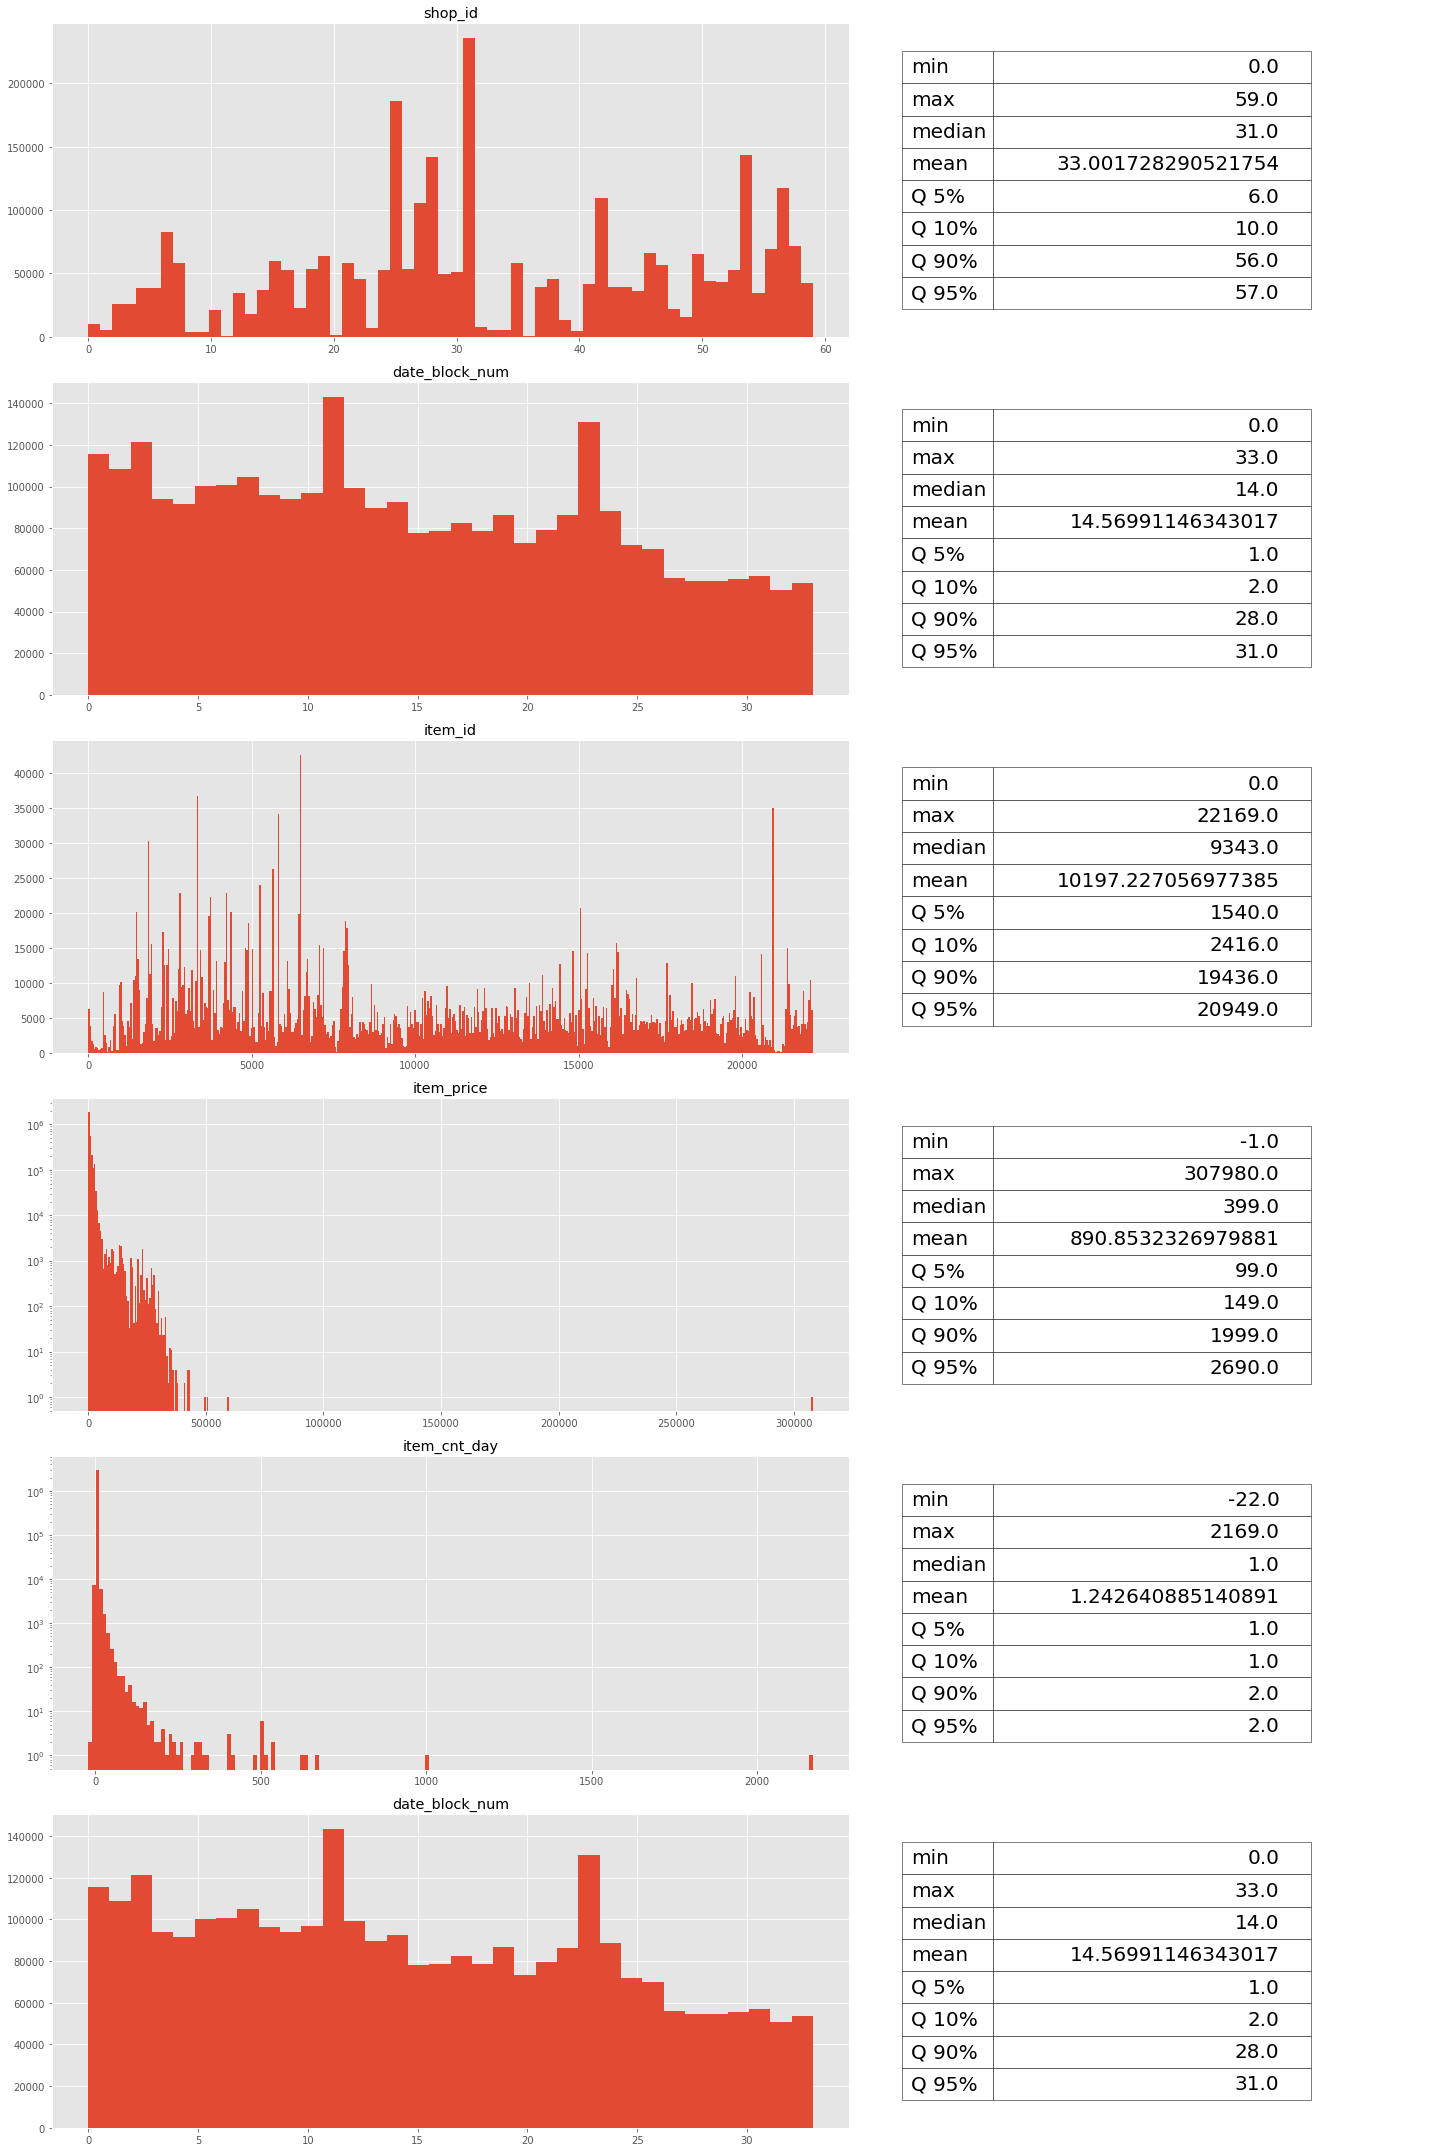

In [15]:
visualize_column_values(sales_train, columns = ["shop_id", "date_block_num", "item_id", "item_price", "item_cnt_day", "date_block_num"], log_scale_cols = ["item_price", "item_cnt_day"])

## Let's look again at item_price and item_cnt without last 10% quantile.

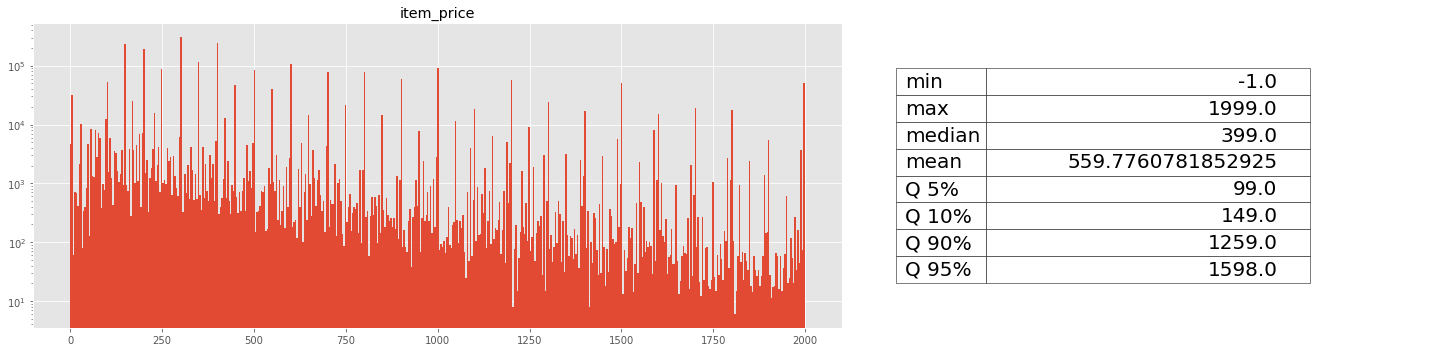

In [16]:
visualize_column_values(sales_train[sales_train["item_price"] <= 1999], columns = ["item_price"], log_scale_cols=["item_price"])

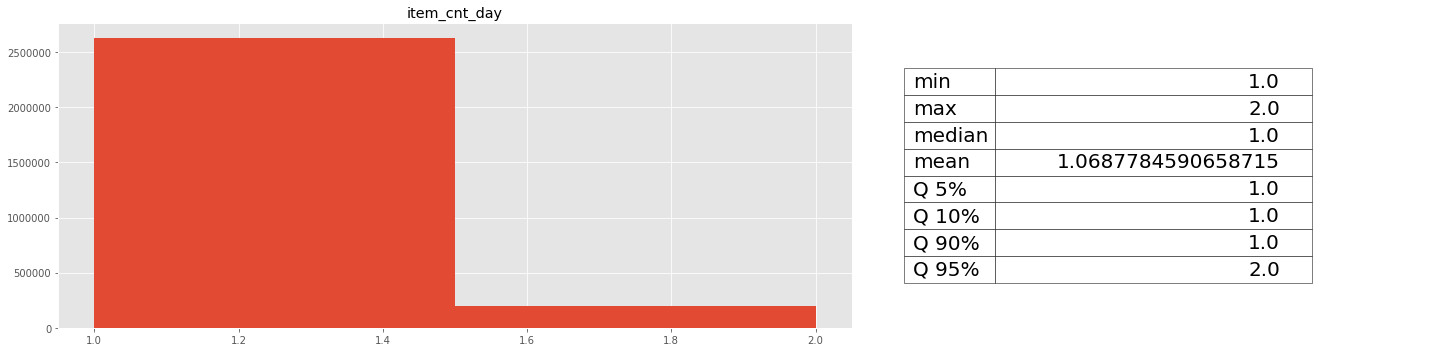

In [17]:
visualize_column_values(sales_train[(sales_train["item_cnt_day"] <= 2) & (sales_train["item_cnt_day"] > 0)], columns = ["item_cnt_day"])

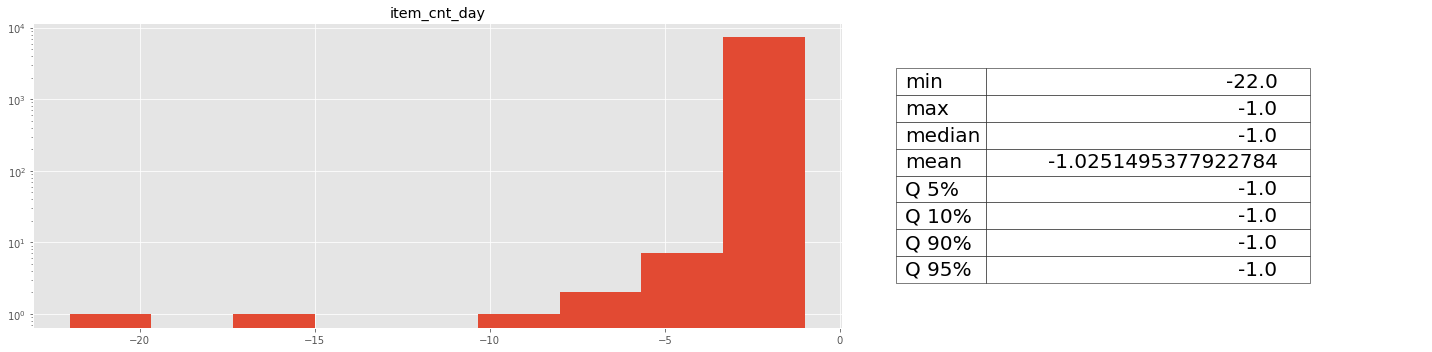

In [18]:
visualize_column_values(sales_train[sales_train["item_cnt_day"] <= 0], columns = ["item_cnt_day"], log_scale_cols=["item_cnt_day"])

# sales_test

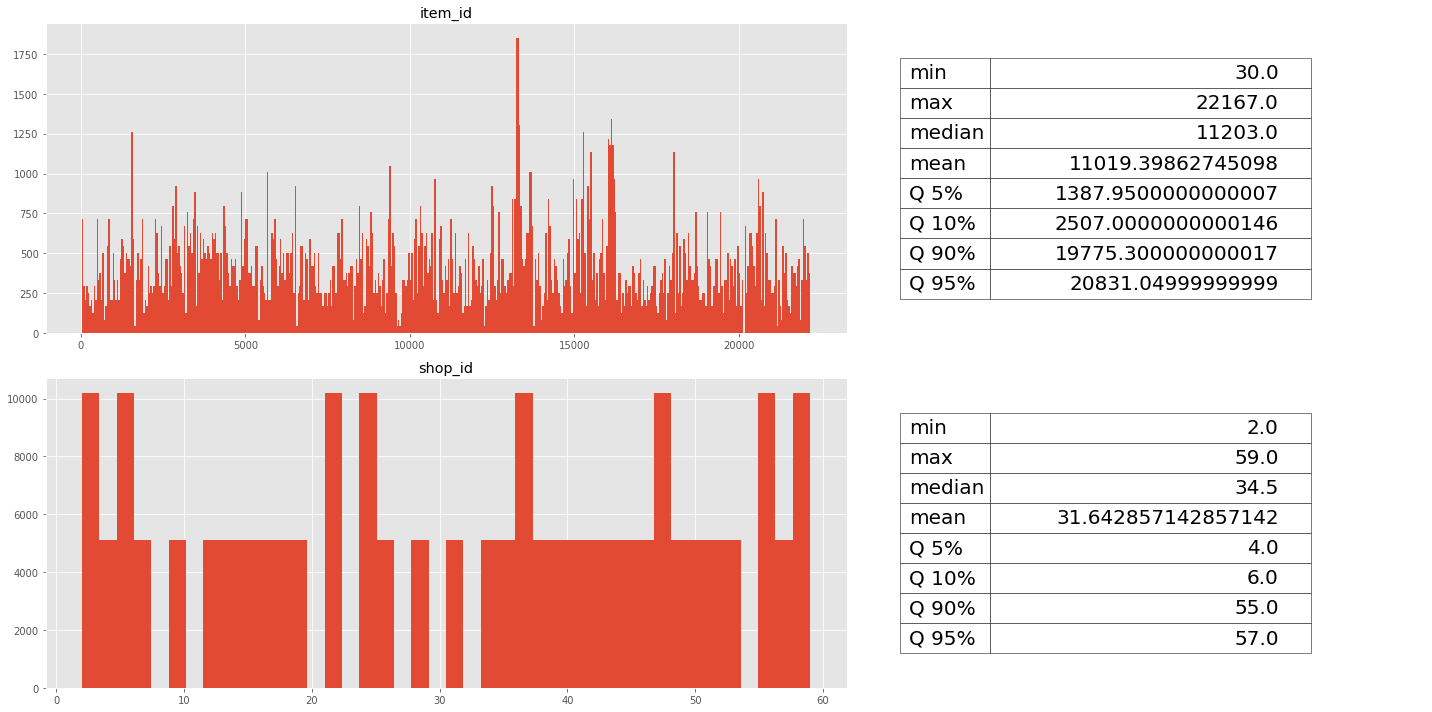

In [19]:
visualize_column_values(sales_test, ["item_id", "shop_id"])

# items

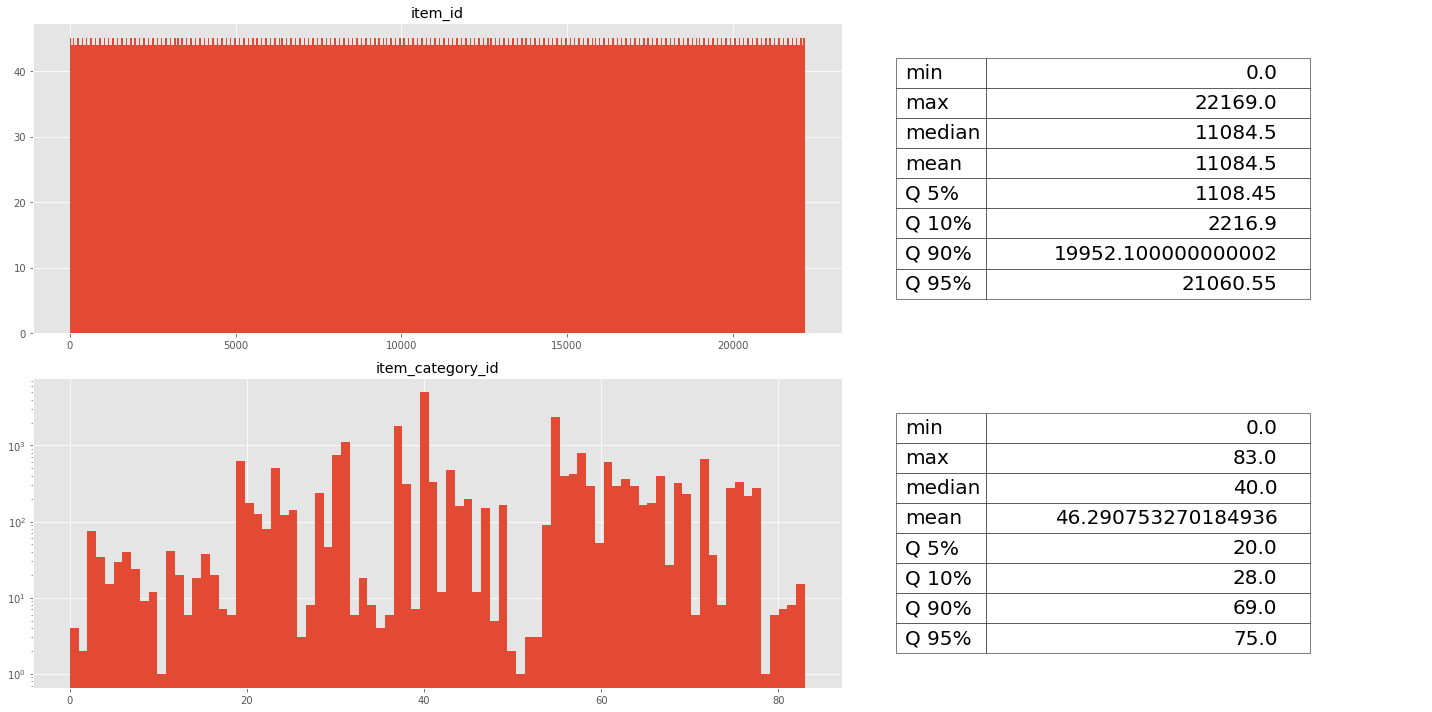

In [20]:
visualize_column_values(items, ["item_id", "item_category_id"], log_scale_cols=["item_category_id"])

# Remove outliners

In [21]:
tmp_frame[tmp_frame["item_price"] > 2690].groupby("item_category_name").agg({"item_price":["max"]}).sort_values(by = [("item_price", "max")], ascending=False).head(10)

,item_price
,max
item_category_name,
Программы - Для дома и офиса,307980.0
Доставка товара,59200.0
Подарки - Сувениры,50999.0
Игровые консоли - XBOX ONE,42990.0
Программы - 1С:Предприятие 8,35300.0
Игровые консоли - PS4,34990.0
Музыка - Винил,29999.0
Программы - Для дома и офиса (Цифра),27900.0


## Remove Radmin 3 instalation
Seems there is a wierd price high above all

In [22]:
sales_train[["item_price", "date"]].groupby("item_price").agg(["count"]).sort_values("item_price", ascending=False).head()

,date
,count
item_price,
307980.0,1
59200.0,1
50999.0,1
49782.0,1
42990.0,4


In [23]:
tmp_res = pd.merge(sales_train[sales_train["item_price"] > 300000], items, how = "left", on = "item_id")
tmp_res = pd.merge(tmp_res, item_categories, how = "left", on = "item_category_id")
tmp_res

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
0,2013-12-13,11,12,6066,307980.0,1.0,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса


In [24]:
sales_test[sales_test["item_id"] == 6066]

,ID,shop_id,item_id


In [25]:
sales_train[sales_train["item_id"] == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,2013-12-13,11,12,6066,307980.0,1.0


Item category: Programs - Home and Office

Item name: Radmin 3 - 522 persons. 

Seems like instalation of remote connection to PC to 522 persons ==> can be removed

In [0]:
sales_train = sales_train[sales_train["item_id"] != 6066]

## Negative or zero price?

In [27]:
sales_train[["item_price", "date"]].groupby("item_price").agg(["count"]).sort_values("item_price", ascending=True).head()

,date
,count
item_price,
-1.0000,1
0.0700,2
0.0875,1
0.0900,1
0.1000,2932


In [28]:
tmp_frame[tmp_frame["item_price"] == -1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name
484683,2013-05-15,4,32,2973,-1.0,1.0,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


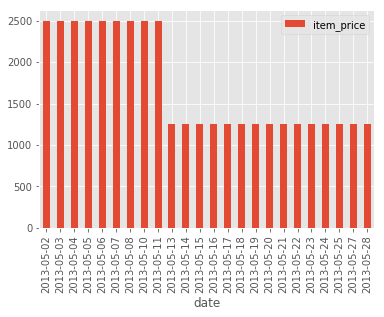

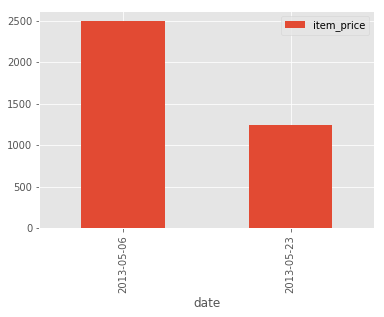

In [29]:
bought_in_month = tmp_frame[(tmp_frame["item_id"] == 2973) & (tmp_frame["item_price"] > 0) & (tmp_frame["date"] > "2013-05-01") & (tmp_frame["date"] < "2013-05-30")]
bought_in_month.groupby("date").mean().reset_index()[["date", "item_price"]].plot.bar(x="date", y="item_price")
bought_in_month[tmp_frame["shop_id"] == 32].groupby("date").mean().reset_index()[["date", "item_price"]].plot.bar(x="date", y="item_price")
plt.show()

Ok, it seems that the price was lowered in the middle of month and this shop has some problem during repricing

In [0]:
item_mean_price = bought_in_month[bought_in_month["date"] == "2013-05-15"]["item_price"].mean()

sales_train.loc[(sales_train["item_price"] == -1) & (sales_train["item_id"] == 2973), "item_price"] = item_mean_price

## Item Id peak

In [31]:
sales_train.groupby("item_id").agg({"item_id":["count"]}).sort_values(by=[("item_id", "count")], ascending=False).head()

,item_id
,count
item_id,
20949,31340
5822,9408
17717,9067
2808,7479
4181,6853


In [32]:
tmp_frame[tmp_frame["item_id"] == 20949][["item_name", "item_category_name"]].drop_duplicates()

,item_name,item_category_name
352379,Фирменный пакет майка 1С Интерес белый (34*42)...,"Подарки - Сумки, Альбомы, Коврики д/мыши"


In [33]:
tmp_frame[tmp_frame["item_category_id"] == 71]["item_name"].drop_duplicates()

26685             Крафт пакет "Интересные подарки"-оранжевый
178618                   Чехол URBAN TOOL slyDog national TR
178619                   Чехол URBAN TOOL slyDog national RU
352379     Фирменный пакет майка 1С Интерес белый (34*42)...
565293     Tucano. Коврик для мыши "Ромашка", Delikatesse...
2542075                     Крафт пакет "Интересные подарки"
Name: item_name, dtype: object

Ok .. it seems like some kind of bag of gift package or T-shirts that should be as a gift ==> may be possible:

Подарки - Сумки, Альбомы, Коврики д/мыши == Gifts - Bags, Albums, Mouse pads

Фирменный пакет майка 1С Интерес белый (34*42) == Corporate package undershirt 1C Interest white (34 * 42)


## Shop names unique check

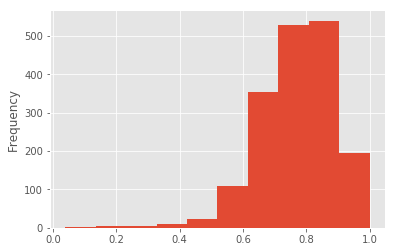

In [34]:
shops_l = shops.copy()
shops_2 = shops.copy()
shops_l["tmp"] = 1
shops_2["tmp"] = 1

dupl_shops = pd.merge(shops_l, shops_2, on = "tmp")
dupl_shops.drop("tmp", axis = 1, inplace = True)
dupl_shops = dupl_shops[dupl_shops["shop_id_x"] > dupl_shops["shop_id_y"]]
dupl_shops["distance"] = dupl_shops.apply(lambda row: stringdist.levenshtein_norm(row["shop_name_x"], row["shop_name_y"]) , axis = 1)
dupl_shops["distance"].plot.hist()

Some names appear to be pretty close one to each other. Let's check it.

In [35]:
dupl_shops[dupl_shops["distance"] < 0.3].sort_values("distance")

,shop_name_x,shop_id_x,shop_name_y,shop_id_y,distance
670,Жуковский ул. Чкалова 39м²,11,Жуковский ул. Чкалова 39м?,10,0.038462
1463,"Москва ТК ""Буденовский"" (пав.К7)",24,"Москва ТК ""Буденовский"" (пав.А2)",23,0.062500
1890,"Москва ТЦ ""Семеновский""",31,"Москва ТЦ ""Перловский""",30,0.173913
3420,"Якутск Орджоникидзе, 56",57,"!Якутск Орджоникидзе, 56 фран",0,0.206897
3481,"Якутск ТЦ ""Центральный""",58,"!Якутск ТЦ ""Центральный"" фран",1,0.206897
2439,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",40,"РостовНаДону ТРК ""Мегацентр Горизонт""",39,0.212766
3278,"Химки ТЦ ""Мега""",54,"Омск ТЦ ""Мега""",38,0.266667
1707,"Москва ТЦ ""МЕГА Теплый Стан"" II",28,"Москва ТЦ ""МЕГА Белая Дача II""",27,0.290323


*   Жуковский ул. Чкалова 39м²	 and Жуковский ул. Чкалова 39м? looks like typo error ==> **same shop**
* Москва ТК "Буденовский" (пав.К7)	and Москва ТК "Буденовский" (пав.A2) ==> not same shop, defferent pavilons in the shopping mall
*  Москва ТЦ "Семеновский"	 and Москва ТЦ "Перловский"	 ==> not the same shop, two shopping malls
* !Якутск Орджоникидзе, 56 фран	 and Якутск Орджоникидзе, 56
 ==> **seems like a same name**
* !Якутск ТЦ "Центральный" фран	 and Якутск ТЦ "Центральный"	 ==> **seems like a same name**
* РостовНаДону ТРК "Мегацентр Горизонт" Островной	 and РостовНаДону ТРК "Мегацентр Горизонт"	==> **seems like a same name**
* Химки ТЦ "Мега"	 and Омск ТЦ "Мега"	 are in different cities ==> not same shop
* Москва ТЦ "МЕГА Теплый Стан" II	 and Москва ТЦ "МЕГА Белая Дача II"	are in same City, but different same of the mall ==> not same shop



In [36]:
same_ids = [(11, 10), (57, 0), (58, 1), (40, 39)]

def print_shop_pairs():
  for first_id, second_id in same_ids:
    first_len = len(sales_train[sales_train["shop_id"] == first_id])
    second_len = len(sales_train[sales_train["shop_id"] == second_id])
    print(f"Train id pair {first_id}/{second_id}: {first_len}/{second_len}")

    first_len = len(sales_test[sales_test["shop_id"] == first_id])
    second_len = len(sales_test[sales_test["shop_id"] == second_id])
    print(f"Test id pair {first_id}/{second_id}: {first_len}/{second_len}")
    
print_shop_pairs()

Train id pair 11/10: 499/21397
Test id pair 11/10: 0/5100
Train id pair 57/0: 117428/9857
Test id pair 57/0: 5100/0
Train id pair 58/1: 71441/5678
Test id pair 58/1: 5100/0
Train id pair 40/39: 4257/13440
Test id pair 40/39: 0/5100


In [37]:
for first_id, second_id in same_ids:
  sales_train.loc[sales_train["shop_id"] == first_id, "shop_id"] = second_id
  sales_test.loc[sales_test["shop_id"] == first_id, "shop_id"] = second_id
  
print_shop_pairs()

Train id pair 11/10: 0/21896
Test id pair 11/10: 0/5100
Train id pair 57/0: 0/127285
Test id pair 57/0: 0/5100
Train id pair 58/1: 0/77119
Test id pair 58/1: 0/5100
Train id pair 40/39: 0/17697
Test id pair 40/39: 0/5100


## Categories names uniqueness

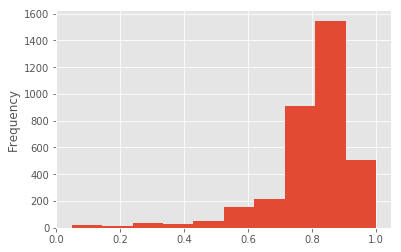

In [38]:
categ_l = item_categories.copy()
categ_2 = item_categories.copy()
categ_l["tmp"] = 1
categ_2["tmp"] = 1

dupl_categ = pd.merge(categ_2, categ_2, on = "tmp")
dupl_categ.drop("tmp", axis = 1, inplace = True)
dupl_categ = dupl_categ[dupl_categ["item_category_name_x"] > dupl_categ["item_category_name_y"]]
dupl_categ["distance"] = dupl_categ.apply(lambda row: stringdist.levenshtein_norm(row["item_category_name_x"], row["item_category_name_y"]) , axis = 1)
dupl_categ["distance"].plot.hist()

In [39]:
dupl_categ[dupl_categ["distance"] < 0.3].sort_values("distance")

,item_category_name_x,item_category_id_x,item_category_name_y,item_category_id_y,distance
1104,Игровые консоли - PSP,13,Игровые консоли - PS4,12,0.047619
1103,Игровые консоли - PSP,13,Игровые консоли - PS3,11,0.047619
1102,Игровые консоли - PSP,13,Игровые консоли - PS2,10,0.047619
1019,Игровые консоли - PS4,12,Игровые консоли - PS3,11,0.047619
934,Игровые консоли - PS3,11,Игровые консоли - PS2,10,0.047619
1018,Игровые консоли - PS4,12,Игровые консоли - PS2,10,0.047619
169,Аксессуары - PS3,2,Аксессуары - PS2,1,0.062500
253,Аксессуары - PS4,3,Аксессуары - PS2,1,0.062500
254,Аксессуары - PS4,3,Аксессуары - PS3,2,0.062500
337,Аксессуары - PSP,4,Аксессуары - PS2,1,0.062500


Seems like categories are OK, but it may be usefull to make new higher category

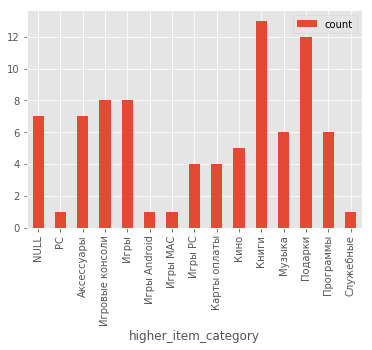

In [40]:
def split_to_higher_category(row):
  if "-" in row["item_category_name"]:
    return row["item_category_name"].split("-")[0].strip()
  else:
    return "NULL"
  
categ_l["higher_item_category"] = categ_l.apply(lambda row: split_to_higher_category(row), axis = 1)
categ_l.groupby("higher_item_category").aggregate({"higher_item_category":["count"]})["higher_item_category"].reset_index().plot.bar(x="higher_item_category", y = "count")

Fix categories for thoes, that does not have - splitter in name

In [0]:
item_categories["higher_category"] = item_categories.apply(lambda row: split_to_higher_category(row), axis = 1)
item_categories.loc[item_categories["item_category_id"] == 81, "higher_category"] = "Media"
item_categories.loc[item_categories["item_category_id"] == 82, "higher_category"] = "Media"
item_categories.loc[item_categories["higher_category"] == "NULL", "higher_category"] = item_categories.loc[item_categories["higher_category"] == "NULL"]["item_category_name"]

Add mean encoding into higher categories

In [42]:
total_categ_count = len(item_categories)
item_categories["higher_category_mean_enc"] = item_categories.groupby("higher_category")["higher_category"].transform("count") / total_categ_count
item_categories.head()

,item_category_name,item_category_id,higher_category,higher_category_mean_enc
0,PC - Гарнитуры/Наушники,0,PC,0.011905
1,Аксессуары - PS2,1,Аксессуары,0.083333
2,Аксессуары - PS3,2,Аксессуары,0.083333
3,Аксессуары - PS4,3,Аксессуары,0.083333
4,Аксессуары - PSP,4,Аксессуары,0.083333


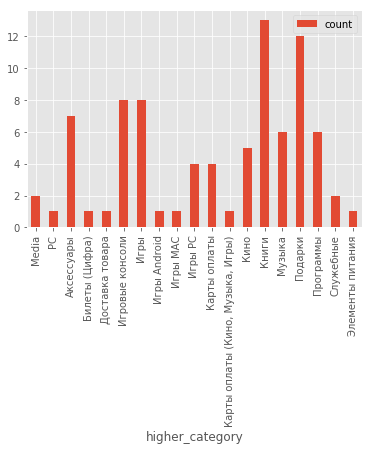

In [43]:
item_categories.groupby("higher_category").aggregate({"higher_category":["count"]})["higher_category"].reset_index().plot.bar(x="higher_category", y = "count")

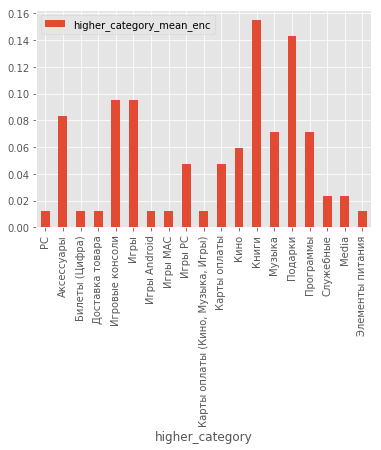

In [44]:
item_categories[["higher_category", "higher_category_mean_enc"]].drop_duplicates().plot.bar(x="higher_category", y = "higher_category_mean_enc")

## Add mean encoding to item categories

In [45]:
total_items = len(items)

tmp_categs = pd.merge(
    item_categories,
    items,
    on = ["item_category_id"]
).groupby("item_category_id").aggregate({"item_id": ["count"]}).reset_index()
tmp_categs.columns = ["item_category_id", "item_category_id_mean_enc"]
tmp_categs["item_category_id_mean_enc"] = tmp_categs["item_category_id_mean_enc"] / total_items

item_categories = pd.merge(
    item_categories,
    tmp_categs,
    on = ["item_category_id"]
)

del tmp_categs

item_categories.head()

,item_category_name,item_category_id,higher_category,higher_category_mean_enc,item_category_id_mean_enc
0,PC - Гарнитуры/Наушники,0,PC,0.011905,0.000180
1,Аксессуары - PS2,1,Аксессуары,0.083333,0.000090
2,Аксессуары - PS3,2,Аксессуары,0.083333,0.003383
3,Аксессуары - PS4,3,Аксессуары,0.083333,0.001534
4,Аксессуары - PSP,4,Аксессуары,0.083333,0.000677


## Removing returned  values

We are askend about total sales in the month. Retuned values should not been in the result.

In [46]:
returned_sales = sales_train["item_cnt_day"] < 0
sales_train = sales_train[returned_sales.map(lambda x: not x)]

print(f"Removed {len([x for x in returned_sales.values if x])} returned items.")
print(f"Train data set consists now {len(sales_train)} items.")

Removed 7356 returned items.
Train data set consists now 2928492 items.


Check in final validation score, if removing returned values helped or not.

# Feature Engineering


## Sales_train
*   Splitting dates into multiple columns
*  Adding seasons
*  Revenues = item_price * item_cnt_day


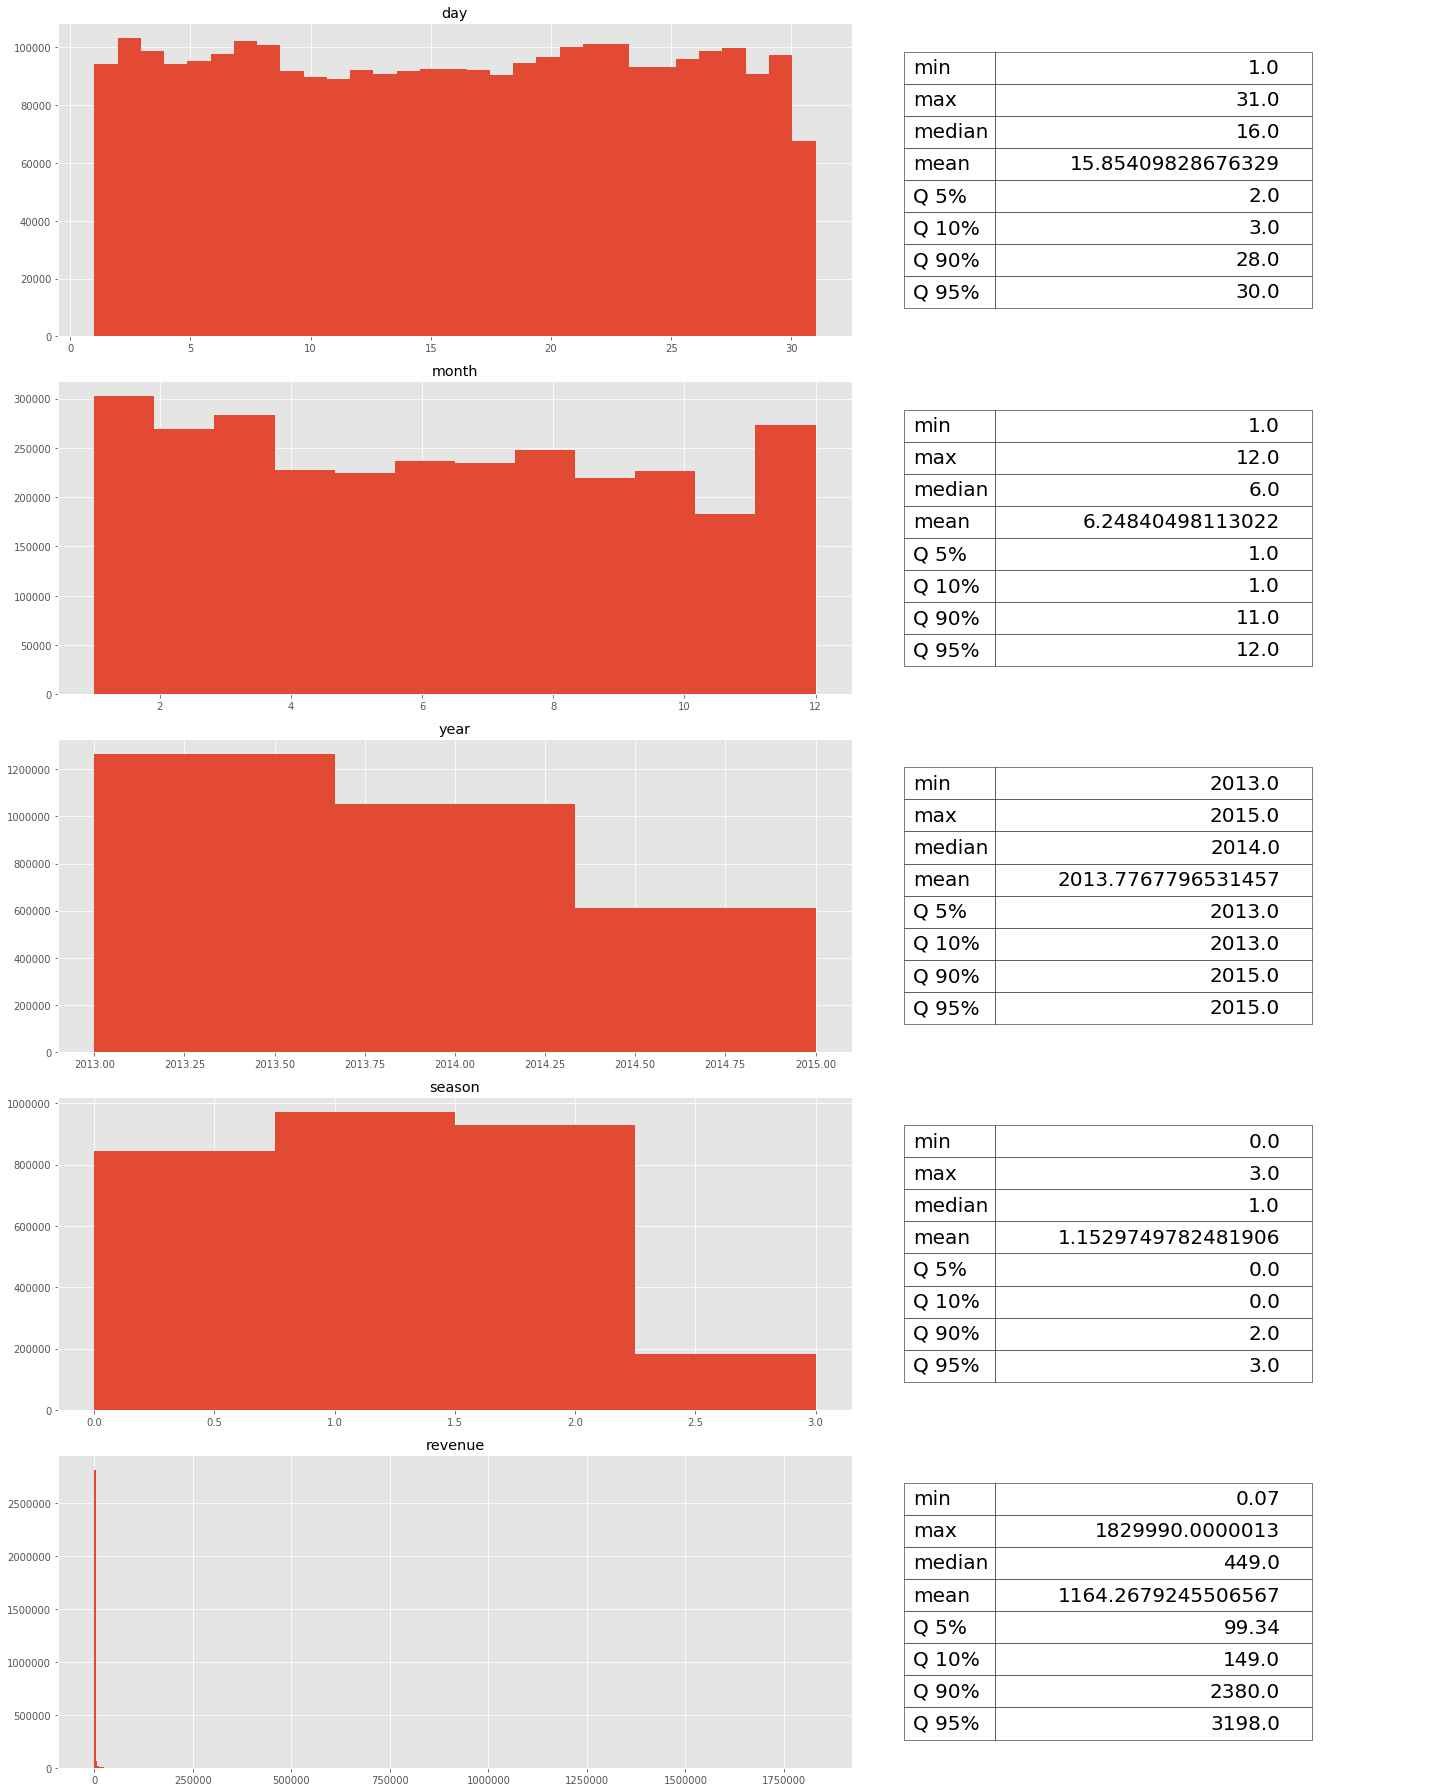

In [47]:
def day_extractor(date_part):
  return lambda input_date: int(input_date.split("-")[date_part])

sales_train["day"] = sales_train["date"].map(day_extractor(2))
sales_train["month"] = sales_train["date"].map(day_extractor(1))
sales_train["year"] = sales_train["date"].map(day_extractor(0))
sales_train["season"] = (((sales_train["month"] % 12) + 1) // 4)
sales_train["revenue"] = sales_train["item_price"] * sales_train["item_cnt_day"]

visualize_column_values(sales_train, ["day", "month", "year", "season", "revenue"])

## Shops

* First name of the shop is name of the city. Add it as mean encoded feature

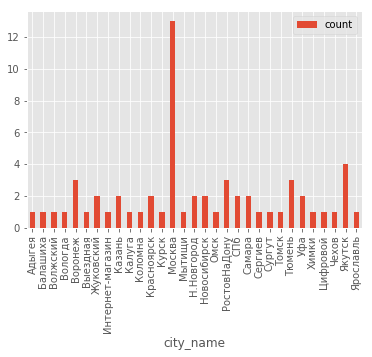

In [48]:
shops["shop_name"] = shops["shop_name"].str.replace("!", "")
shops["city_name"] = shops.apply(lambda row: row["shop_name"].split(" ")[0], axis = 1)
number_of_shops = len(shops)
shops["city_name_mean_enc"] = shops.groupby("city_name")["city_name"].transform("count") / number_of_shops
shops.groupby("city_name").aggregate({"city_name": ["count"]})["city_name"].reset_index().plot.bar(x = "city_name", y = "count")

In [49]:
shops.head()

,shop_name,shop_id,city_name,city_name_mean_enc
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,0.066667
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,0.066667
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0.016667
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0.016667
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,0.016667


# Aggegate features

In [0]:
train = pd.merge(sales_train, items, how = "left", on = "item_id")
train = pd.merge(train, item_categories, how = "left", on = "item_category_id")
train = pd.merge(train, shops, how = "left", on = "shop_id")

In [0]:
del tmp_frame

In [0]:
assert len(sales_train) == len(train), "Len is not the same"

In [53]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year,season,revenue,item_name,item_category_id,item_category_name,higher_category,higher_category_mean_enc,item_category_id_mean_enc,shop_name,city_name,city_name_mean_enc
0,2013-01-02,0,59,22154,999.00,1.0,2,1,2013,0,999.00,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,Кино,0.059524,0.080289,"Ярославль ТЦ ""Альтаир""",Ярославль,0.016667
1,2013-01-03,0,25,2552,899.00,1.0,3,1,2013,0,899.00,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,Музыка,0.071429,0.035634,"Москва ТРК ""Атриум""",Москва,0.216667
2,2013-01-06,0,25,2554,1709.05,1.0,6,1,2013,0,1709.05,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,Музыка,0.071429,0.035634,"Москва ТРК ""Атриум""",Москва,0.216667
3,2013-01-15,0,25,2555,1099.00,1.0,15,1,2013,0,1099.00,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,Музыка,0.071429,0.017907,"Москва ТРК ""Атриум""",Москва,0.216667
4,2013-01-10,0,25,2564,349.00,1.0,10,1,2013,0,349.00,DEEP PURPLE Perihelion: Live In Concert DVD (К...,59,Музыка - Музыкальное видео,Музыка,0.071429,0.013261,"Москва ТРК ""Атриум""",Москва,0.216667


In [0]:
# aggregate_features = ["sum", "mean", "max", "min", "std"]
aggregate_features = ["sum", "mean", "std"]


def flatten(nested_list):
  for first_list in nested_list:
    for item in first_list:
      yield item

def create_col_names(col_name):
  return [f"{col_name}_{f}" for f in aggregate_features]

def aggregate_frame(group_by_cols, feature_cols, data_frame = train, frame_aggregate_features = aggregate_features):
  aggr_dict = {feature: frame_aggregate_features for feature in feature_cols}
  tmp_frame = data_frame.groupby(group_by_cols).aggregate(aggr_dict).fillna(-1).reset_index()
  flat_list = list(flatten([create_col_names(item) for item in feature_cols]))
  tmp_frame.columns = group_by_cols + flat_list
  return tmp_frame

In [0]:
sales_columns = ["item_cnt_day", "revenue"]

In [56]:
monthly_shop_item_sale = aggregate_frame(["shop_id", "item_id", "date_block_num", "month", "year", "season"], sales_columns)

#Clip according rules from competition
monthly_shop_item_sale["item_cnt_day_sum"] = monthly_shop_item_sale["item_cnt_day_sum"].clip(0, 20) 
monthly_shop_item_sale.head()

,shop_id,item_id,date_block_num,month,year,season,item_cnt_day_sum,item_cnt_day_mean,item_cnt_day_std,revenue_sum,revenue_mean,revenue_std
0,0,30,1,2,2013,0,20.0,3.444444,2.242271,8215.0,912.777778,594.201729
1,0,30,2,3,2013,1,20.0,1.600000,0.736788,9576.0,638.400000,293.978571
2,0,30,3,4,2013,1,3.0,1.000000,0.000000,1197.0,399.000000,0.000000
3,0,30,4,5,2013,1,1.0,1.000000,-1.000000,399.0,399.000000,-1.000000
4,0,30,6,7,2013,2,1.0,1.000000,-1.000000,399.0,399.000000,-1.000000


In [57]:
monthly_shop_sale = aggregate_frame(["shop_id", "date_block_num"], sales_columns)
monthly_shop_sale.head()

,shop_id,date_block_num,item_cnt_day_sum,item_cnt_day_mean,item_cnt_day_std,revenue_sum,revenue_mean,revenue_std
0,0,0,5578.0,1.163781,0.559564,2966412.0,618.905070,1361.077428
1,0,1,6127.0,1.209913,0.695896,3670958.0,724.912717,1764.124614
2,0,2,6596.0,1.197531,0.729802,4289394.0,778.757081,1349.470453
3,0,3,5509.0,1.130283,0.531053,3105392.0,637.134181,1138.738978
4,0,4,5245.0,1.139970,0.620634,2742440.0,596.053032,1234.329652


In [58]:
season_shop_sale = aggregate_frame(["shop_id", "season", "year"], sales_columns)
season_shop_sale.head()

,shop_id,season,year,item_cnt_day_sum,item_cnt_day_mean,item_cnt_day_std,revenue_sum,revenue_mean,revenue_std
0,0,0,2013,21203.0,1.281690,1.611329,1.649416e+07,997.047875,7068.315391
1,0,0,2014,16992.0,1.276922,1.449966,1.743588e+07,1310.278801,4560.867787
2,0,0,2015,7705.0,1.195871,0.870968,7.409367e+06,1149.987118,3674.372862
3,0,1,2013,23354.0,1.176998,0.780230,1.328607e+07,669.593337,1364.412189
4,0,1,2014,17188.0,1.209060,0.965849,1.293299e+07,909.749156,3186.496793


In [59]:
season_shop_category_sale = aggregate_frame(["shop_id", "season", "item_category_id", "year"], sales_columns)
season_shop_category_sale.head()

,shop_id,season,item_category_id,year,item_cnt_day_sum,item_cnt_day_mean,item_cnt_day_std,revenue_sum,revenue_mean,revenue_std
0,0,0,0,2013,1.0,1.000000,-1.000000,93.0,93.000000,-1.000000
1,0,0,1,2013,1.0,1.000000,-1.000000,283.0,283.000000,-1.000000
2,0,0,2,2013,244.0,1.326087,0.748166,418628.1,2275.152717,1476.386837
3,0,0,2,2014,142.0,1.118110,0.429362,272766.0,2147.763780,1267.285672
4,0,0,2,2015,10.0,1.111111,0.333333,28300.0,3144.444444,908.668134


In [60]:
monthly_shop_category_sale = aggregate_frame(["shop_id", "date_block_num", "item_category_id"], sales_columns)
monthly_shop_category_sale.head()

,shop_id,date_block_num,item_category_id,item_cnt_day_sum,item_cnt_day_mean,item_cnt_day_std,revenue_sum,revenue_mean,revenue_std
0,0,0,2,53.0,1.177778,0.441531,99380.0,2208.444444,842.963322
1,0,0,3,28.0,1.555556,0.704792,6776.0,376.444444,170.559709
2,0,0,4,16.0,1.142857,0.534522,11331.0,809.357143,795.559755
3,0,0,5,28.0,1.076923,0.271746,22499.0,865.346154,751.704513
4,0,0,6,65.0,1.181818,0.434226,113486.0,2063.381818,3003.811064


In [61]:
monthly_category_sale = aggregate_frame(["date_block_num", "item_category_id"], sales_columns)
monthly_category_sale.head()

,date_block_num,item_category_id,item_cnt_day_sum,item_cnt_day_mean,item_cnt_day_std,revenue_sum,revenue_mean,revenue_std
0,0,0,1.0,1.000000,-1.000000,148.00,148.000000,-1.000000
1,0,1,1.0,1.000000,-1.000000,148.00,148.000000,-1.000000
2,0,2,1395.0,1.108903,0.378500,2864399.69,2276.947289,1268.680828
3,0,3,441.0,1.324324,0.669861,209658.90,629.606306,373.600458
4,0,4,255.0,1.085106,0.322238,235677.00,1002.880851,798.417301


In [62]:
season_category_sale = aggregate_frame(["season", "item_category_id", "year"], sales_columns)
season_category_sale.head()

,season,item_category_id,year,item_cnt_day_sum,item_cnt_day_mean,item_cnt_day_std,revenue_sum,revenue_mean,revenue_std
0,0,0,2013,2.0,1.000000,0.000000,241.00,120.500000,38.890873
1,0,1,2013,2.0,1.000000,0.000000,431.00,215.500000,95.459415
2,0,2,2013,4792.0,1.147784,0.470963,9639397.99,2308.837842,1487.426643
3,0,2,2014,2667.0,1.089016,0.338559,5832521.30,2381.593018,1487.952889
4,0,2,2015,682.0,1.049231,0.249575,1897400.91,2919.078323,961.895019


In [63]:
monthly_city_sale = aggregate_frame(["city_name", "date_block_num"], sales_columns)
monthly_city_sale.head()

,city_name,date_block_num,item_cnt_day_sum,item_cnt_day_mean,item_cnt_day_std,revenue_sum,revenue_mean,revenue_std
0,Адыгея,0,1151.0,1.079737,0.318775,1091137.01,1023.580685,1926.264742
1,Адыгея,1,489.0,1.079470,0.308934,523629.00,1155.913907,1592.137088
2,Адыгея,2,756.0,1.115044,0.684311,734847.00,1083.845133,1560.568954
3,Адыгея,3,585.0,1.055957,0.292354,615909.00,1111.749097,1611.879333
4,Адыгея,4,553.0,1.041431,0.242193,542429.00,1021.523540,1568.143100


In [64]:
monthly_category_city_sale = aggregate_frame(["city_name", "item_category_id", "date_block_num"], sales_columns)
monthly_category_city_sale.head()

,city_name,item_category_id,date_block_num,item_cnt_day_sum,item_cnt_day_mean,item_cnt_day_std,revenue_sum,revenue_mean,revenue_std
0,Адыгея,2,0,26.0,1.083333,0.282330,51476.02,2144.834167,1029.334980
1,Адыгея,2,1,21.0,1.105263,0.315302,36253.00,1908.052632,1413.718048
2,Адыгея,2,2,10.0,1.250000,0.707107,32627.00,4078.375000,5773.906351
3,Адыгея,2,3,15.0,1.000000,0.000000,29194.00,1946.266667,1491.755891
4,Адыгея,2,4,8.0,1.142857,0.377964,14929.00,2132.714286,1262.181275


In [65]:
monthly_higher_category_sale = aggregate_frame(["higher_category", "date_block_num"], sales_columns)
monthly_higher_category_sale.head()

,higher_category,date_block_num,item_cnt_day_sum,item_cnt_day_mean,item_cnt_day_std,revenue_sum,revenue_mean,revenue_std
0,Media,0,1551.0,2.184507,1.871330,73010.0,102.830986,118.167303
1,Media,1,1304.0,2.158940,1.993664,54337.0,89.961921,104.797682
2,Media,2,1231.0,2.038079,1.490781,60295.0,99.826159,109.948463
3,Media,3,1136.0,2.127341,2.436950,55471.0,103.878277,125.786166
4,Media,4,1252.0,2.268116,2.203083,58250.0,105.525362,125.383590


In [66]:
season_higher_category_sale = aggregate_frame(["higher_category", "season", "year"], sales_columns)
season_higher_category_sale.head()

,higher_category,season,year,item_cnt_day_sum,item_cnt_day_mean,item_cnt_day_std,revenue_sum,revenue_mean,revenue_std
0,Media,0,2013,3042.0,2.163585,1.903803,134353.00,95.556899,109.823083
1,Media,0,2014,221.0,2.255102,1.777936,9671.00,98.683673,73.710858
2,Media,0,2015,50.0,50.000000,-1.000000,650.00,650.000000,-1.000000
3,Media,1,2013,4808.0,2.155087,2.120616,223030.00,99.968624,117.865557
4,Media,1,2014,331.0,2.546154,2.453005,14048.15,108.062692,109.763897


In [67]:
season_shop_item_sale = aggregate_frame(["shop_id", "item_id", "season", "year"], sales_columns)
season_shop_item_sale.head()

,shop_id,item_id,season,year,item_cnt_day_sum,item_cnt_day_mean,item_cnt_day_std,revenue_sum,revenue_mean,revenue_std
0,0,30,0,2013,34.0,2.833333,2.208798,8722.0,726.833333,608.225262
1,0,30,0,2014,3.0,1.000000,0.000000,507.0,169.000000,0.000000
2,0,30,0,2015,3.0,1.000000,0.000000,507.0,169.000000,0.000000
3,0,30,1,2013,28.0,1.473684,0.696692,11172.0,588.000000,277.980215
4,0,30,1,2014,1.0,1.000000,-1.000000,169.0,169.000000,-1.000000


In [68]:
print(f"Max date: {train.date.max()}\nMin date: {train.date.min()}")

Max date: 2015-10-31
Min date: 2013-01-01


In [69]:
print(f"Max date_block_num: {train.date_block_num.max()}\nMin date_block_num: {train.date_block_num.min()}")

Max date_block_num: 33
Min date_block_num: 0


## Put everything together for one month

In [0]:
block_num_base = train[["date_block_num", "month", "year", "season"]].drop_duplicates()
block_num_base["tmp"] = 1

shop_item_base = train[["shop_id", "item_id"]].drop_duplicates()
shop_item_base["tmp"] = 1

sales_base = pd.merge(
    block_num_base,
    shop_item_base,
    how = "inner",
    on = "tmp"
)
sales_base = sales_base.drop(["tmp"], axis = 1)

assert len(block_num_base) * len(shop_item_base) == len(sales_base), "Target value is not product"

del block_num_base
del shop_item_base

## Print correlation between basic columns

In [0]:
def rename_conditionaly(column, prefix, join_cols):
  if column in join_cols:
    return column
  else:
    return f"{prefix}_{column}"

def rename_and_merge(left_frame, right_frame, join_cols, right_cols_prefix):
  tmp_frame = right_frame.copy()
  new_cols = {col : f"{right_cols_prefix}_{col}" for col in right_frame.columns if not col in join_cols}
  tmp_frame.rename(index=str, columns=new_cols, inplace = True)
  return pd.merge(
      left_frame,
      tmp_frame,
      on = join_cols,
      how = "left",
      suffixes=(False, False)
  )

def rename_and_merge_season(left_frame, season_frame, join_cols, season_cols_prefix):
  tmp_seasons = season_frame.copy()
  tmp_seasons["year"] = tmp_seasons["year"] + 1
  return rename_and_merge(left_frame, tmp_seasons, join_cols + ["season", "year"], season_cols_prefix)
   
monthly_train = pd.merge(
    sales_base, #[(sales_base.shop_id == 0) & (sales_base.item_id == 30)],
    monthly_shop_item_sale, #[(monthly_shop_item_sale.shop_id == 0) & (monthly_shop_item_sale.item_id == 30)],
    how = "left",
    on = ["shop_id", "item_id", "date_block_num", "month", "year", "season"]
).fillna({"item_cnt_day_sum": 0}).fillna(-1)
  
  
monthly_train = pd.merge(
  monthly_train,
  items,
  on = ["item_id"]
)

monthly_train = pd.merge(
  monthly_train,
  item_categories,
  on = ["item_category_id"]
)

monthly_train = pd.merge(
  monthly_train,
  shops,
  on = ["shop_id"]
)

monthly_train = rename_and_merge(
    monthly_train,
    monthly_shop_sale,
    ["shop_id", "date_block_num"],
    "shop_month"
)

monthly_train = rename_and_merge(
    monthly_train,
    monthly_shop_category_sale,
    ["shop_id", "item_category_id", "date_block_num"],
    "shop_category_month"
)

monthly_train = rename_and_merge(
    monthly_train,
    monthly_category_sale,
    ["item_category_id", "date_block_num"],
    "category_month"
)

monthly_train = rename_and_merge(
    monthly_train,
    monthly_city_sale,
    ["city_name", "date_block_num"],
    "city_month"
)

monthly_train = rename_and_merge(
    monthly_train,
    monthly_category_city_sale,
    ["city_name", "item_category_id", "date_block_num"],
    "city_category_month"
)

monthly_train = rename_and_merge(
    monthly_train,
    monthly_higher_category_sale,
    ["higher_category", "date_block_num"],
    "higher_category_month"
)

monthly_train = rename_and_merge_season(
    monthly_train,
    season_shop_sale,
    ["shop_id"],
    "shop_season"
)

monthly_train = rename_and_merge_season(
    monthly_train,
    season_category_sale,
    ["item_category_id"],
    "category_season"
)

monthly_train = rename_and_merge_season(
    monthly_train,
    season_higher_category_sale,
    ["higher_category"],
    "higher_category_season"
)

monthly_train = rename_and_merge_season(
    monthly_train,
    season_shop_category_sale,
    ["shop_id", "item_category_id"],
    "shop_category_season"
)

monthly_train = rename_and_merge_season(
    monthly_train,
    season_shop_item_sale,
    ["shop_id", "item_id"],
    "shop_item_season"
)

monthly_train.head()

In [0]:
corr = monthly_train.corr()

In [0]:
size = 30
fig, ax = plt.subplots(figsize=(size, size))
cax = ax.matshow(corr)

fig.colorbar(cax)

ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.columns)))
ax.set_xticklabels(corr.columns)
ax.set_yticklabels(corr.columns)

# Set ticks on both sides of axes on
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)
# Rotate and align bottom ticklabels
plt.setp([tick.label1 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="right", va="center", rotation_mode="anchor")
# Rotate and align top ticklabels
plt.setp([tick.label2 for tick in ax.xaxis.get_major_ticks()], rotation=45,
         ha="left", va="center",rotation_mode="anchor")

fig.tight_layout()


plt.show()


In [0]:
corr = corr.unstack().reset_index()
corr.columns = ["first_column", "second_column", "correlation"]

Remove all statistics columns with high correlation

In [0]:
def is_drop_col(col_name):
  suffixes = [f"_{feature}" for feature in aggregate_features]
  matches = [col_name.endswith(suffix) for suffix in suffixes]
  return (not col_name == "item_cnt_day_sum") & any(matches)


threshold = 0.9
cols_to_drop = [col for col in corr[np.abs((corr["correlation"]) > threshold) & (corr["first_column"] != corr["second_column"])]["second_column"].values if is_drop_col(col)]
print(f"Drop {len(set(cols_to_drop))} from original {len(monthly_train.columns)} columns")

monthly_train = monthly_train.drop(cols_to_drop, axis=1)

In [0]:
monthly_train.columns

## Downscale all final columns

In [0]:
monthly_train = monthly_train.fillna(-1)

In [0]:
def print_int_values():
  for index, col_type in enumerate(monthly_train.dtypes):
    col_name = monthly_train.columns[index]
    if ("int" in str(col_type)):
      print(col_name, monthly_train[col_name].max(), monthly_train[col_name].min()) 

      
print_int_values()

In [0]:
downscale_int = {
    "shop_id": np.uint8, 
    "item_id": np.uint16,
    "date_block_num": np.uint8,
    "year": np.uint16,
    "season": np.uint8,
    "item_category_id": np.uint8, 
    "month": np.uint8
}

In [0]:
for index, col_type in enumerate(monthly_train.dtypes):
  col_name = monthly_train.columns[index]
  if (col_type == "int64"):
    monthly_train[col_name] = monthly_train[col_name].astype(downscale_int[col_name], copy=False)

In [0]:
print_int_values()

In [0]:
orig_min = monthly_train["item_cnt_day_sum"].min()
orig_max = monthly_train["item_cnt_day_sum"].max()
monthly_train["item_cnt_day_sum"] = monthly_train["item_cnt_day_sum"].astype(np.uint8) 
assert orig_max == monthly_train["item_cnt_day_sum"].max()
assert orig_min == monthly_train["item_cnt_day_sum"].min()

In [0]:
for col in monthly_train.columns:
  if ("_cnt_" in col) & (not "_std" in col) & (not "_mean" in col):
    if monthly_train[col].dtype == "float64":
      orig_min = int(monthly_train[col].min())
      orig_max = int(monthly_train[col].max())
      target_type = np.int16
      if orig_max > 32767:
        target_type = np.int32
      monthly_train[col] = monthly_train[col].astype(target_type)
      assert orig_max == monthly_train[col].max()
      assert orig_min == monthly_train[col].min()

In [0]:
for col in monthly_train.columns:
  if monthly_train[col].dtype == "float64":
    monthly_train[col] = monthly_train[col].astype(np.float32)

In [0]:
import gc

del corr
del fig
del ax
del monthly_shop_item_sale
del monthly_shop_sale
del season_shop_sale
del season_shop_category_sale
del monthly_shop_category_sale
del monthly_category_sale
del season_category_sale
del monthly_city_sale
del monthly_category_city_sale
del monthly_higher_category_sale
del season_higher_category_sale
del season_shop_item_sale

gc.collect()

## Stack months from the past into training set

In [0]:
def join_frames_together(input_frame, monthly_frame, block_shift, join_col=["shop_id", "item_id", "date_block_num"]):
  tmp_frame = monthly_frame.copy()
  tmp_frame["date_block_num"] = tmp_frame["date_block_num"] + block_shift
  tmp_frame = tmp_frame.drop(['year', 'season', 'item_name', 'item_category_id',
       'item_category_name', 'higher_category', 'higher_category_mean_enc',
       'item_category_id_mean_enc', 'shop_name', 'city_name',
       'city_name_mean_enc'], axis = 1)
  tmp_frame = tmp_frame.rename({col : f"{col}_{block_shift}" for col in tmp_frame.columns if col not in join_col}, axis = 1)
  return pd.merge(
      input_frame,
      tmp_frame,
      how = "left",
      on = join_col
  )

months = [1,2,3,4,5,6,8,10,12]


time_series_train = monthly_train
for month in tqdm(months):
  time_series_train = join_frames_together(time_series_train, monthly_train, month)
  
time_series_train = time_series_train.fillna(-1)

In [0]:
def add_target_value(input_frame, monthly_frame):
  tmp_frame = monthly_frame[["shop_id", "item_id", "date_block_num", "item_cnt_day_sum"]].copy()
  tmp_frame["date_block_num"] = tmp_frame["date_block_num"] - 1
  tmp_frame = tmp_frame.rename({"item_cnt_day_sum" : "item_cnt_month"}, axis = 1)
  return pd.merge(
      input_frame,
      tmp_frame,
      how = "left",
      on = ["shop_id", "item_id", "date_block_num"]
  )

time_series_train = add_target_value(time_series_train, monthly_train)
time_series_train = time_series_train.fillna({"item_cnt_month": 0})
time_series_train = time_series_train[time_series_train["date_block_num"].isin(list(range(13,32,1)))]
print(len(time_series_train))

In [0]:
time_series_train.head()

In [0]:
time_series_train.to_parquet("./time_series_train.parquet")

In [0]:
copyfile("./time_series_train.parquet", f"{FOLDER}/time_series_train.parquet")

# Load prepared data

In [0]:
time_series_train = pd.read_parquet(f"{FOLDER}/time_series_train.parquet")
print(len(time_series_train))

In [0]:
time_series_train.head()

In [0]:
time_series_train[(time_series_train.shop_id == 0) & (time_series_train.item_id == 30)].sort_values("date_block_num")[["date_block_num","item_cnt_day_sum", "item_cnt_month"]]

# Prepare for basic catboost training

In [0]:
valid_split_block = 32

X_train = time_series_train[time_series_train["date_block_num"] < valid_split_block]
X_valid = time_series_train[time_series_train["date_block_num"] >= valid_split_block]
y_train = X_train["item_cnt_month"]
y_valid = X_valid["item_cnt_month"]

# Finding good CV

In [0]:
train_shop_id = set(sales_train["shop_id"])
test_shop_id = set(sales_test["shop_id"])
intersect_shop_id = train_shop_id.intersection(test_shop_id)
not_in_test_shop_id = [shop_id for shop_id in train_shop_id if not shop_id in test_shop_id]

print(f"Train shop id: {len(train_shop_id)}\nTest shop id:{len(test_shop_id)}\nIntersection ids:{len(intersect_shop_id)}")
print(f"Not in test:{not_in_test_shop_id}")

In [0]:
train_item_id = set(sales_train["item_id"])
test_item_id = set(sales_test["item_id"])
intersect_item_id = train_item_id.intersection(test_item_id)
not_in_test_item_id = [item_id for item_id in train_item_id if not item_id in test_item_id]
not_in_train_item_id = [item_id for item_id in test_item_id if not item_id in train_item_id]
percentage_not_in_train = len(not_in_train_item_id)/len(test_item_id)

print(f"Train item id: {len(train_item_id)}\nTest item id:{len(test_item_id)}\nIntersection ids:{len(intersect_item_id)}")
print(f"Not in test:{len(not_in_test_item_id)}")
print(f"Not in train:{len(not_in_train_item_id)}")
print(f"Percentage not in train:{percentage_not_in_train * 100:.2f}%")

In [0]:
plt.title("Categories distribution")
ax = pd.merge(
    pd.DataFrame({"item_id": list(train_item_id)}),
    items,
    on = "item_id"
)["item_category_id"].plot.hist(label="Train")


ax2 = pd.merge(
    pd.DataFrame({"item_id": list(test_item_id)}),
    items,
    on = "item_id"
)["item_category_id"].plot.hist(label="Test")

plt.legend()
plt.show()

## Conclusion

* All shops that are in the test data set are also in train data set. Not all shops from trian data set are in test. 
* All categories are the same in train and test dataset. Also the distribution looks like the same, so we can use this information in splitting data sets.
* No all items in test dataset are in train. So the validation split also has to reflect this situation